<h3>This code aims to build a model to identify ships in SAR Images.</h3> 
<h3>Several of the needed images have been pooled from another dataset called - SSDD (SAR Ship Detection Dataset).</h3>
<a href="https://github.com/TianwenZhang0825/Official-SSDD">Link to the Dataset</a>

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Activation, add
import tensorflow as tf

In [2]:
train_path ='ship_dataset/train/'
test_path = 'ship_dataset/test/'
train_batches = ImageDataGenerator(validation_split=0.1) \
                .flow_from_directory(directory=train_path,  
                                     classes = ['land','ship'], 
                                     subset='training',
                                     batch_size=10)

validation_batches = ImageDataGenerator(validation_split=0.1) \
                     .flow_from_directory(directory=train_path, 
                                          classes = ['land', 'ship'], 
                                          subset='validation',
                                          batch_size=10)
                
test_batches = ImageDataGenerator() \
                    .flow_from_directory(directory=test_path, 
                                        classes = ['land', 'ship'], 
                                         batch_size=10, 
                                         shuffle=False)

Found 11119 images belonging to 2 classes.
Found 1234 images belonging to 2 classes.
Found 3090 images belonging to 2 classes.


In [5]:
# import os
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
# import numpy as np

# train_path = 'ship_dataset/train/'
# test_path = 'ship_dataset/test/'

# # Define augmentation parameters
# augmentation_params = {
#     'rotation_range': 20,
#     'width_shift_range': 0.2,
#     'height_shift_range': 0.2,
#     'shear_range': 0.2,
#     'zoom_range': 0.2,
#     'horizontal_flip': True,
#     'fill_mode': 'nearest'
# }

# # Create an ImageDataGenerator for ships with augmentation
# datagen_ship = ImageDataGenerator(**augmentation_params)

# def augment_and_save_images(source_folder, destination_folder, class_name, target_count):
#     """
#     Augments images and saves them to balance the dataset.

#     Args:
#         source_folder (str): Path to the folder containing the original images.
#         destination_folder (str): Path to save the augmented images.
#         class_name (str): Class name of the images to augment.
#         target_count (int): Desired number of images after augmentation.

#     Returns:
#         None
#     """

#     class_folder = os.path.join(source_folder, class_name)
#     save_folder = os.path.join(destination_folder, class_name)
#     os.makedirs(save_folder, exist_ok=True)

#     # Count existing images
#     existing_images = os.listdir(class_folder)
#     existing_count = len(existing_images)
#     print(f"Existing {class_name} images: {existing_count}")

#     # Augment images until the target count is reached
#     augment_count = target_count - existing_count
#     if augment_count <= 0:
#         print(f"No augmentation needed for {class_name}")
#         return

#     print(f"Augmenting {augment_count} images for {class_name}")
#     for img_name in existing_images:
#         img_path = os.path.join(class_folder, img_name)
#         img = load_img(img_path)
#         img_array = img_to_array(img)
#         img_array = np.expand_dims(img_array, axis=0)

#         # Generate and save augmented images
#         i = 0
#         for batch in datagen_ship.flow(img_array, batch_size=1):
#             aug_img = batch[0].astype(np.uint8)
#             aug_img_path = os.path.join(save_folder, f"aug_{i}_{img_name}")
#             save_img(aug_img_path, aug_img)
#             i += 1
#             if i >= augment_count:
#                 break
#         if i >= augment_count:
#             break

# Paths for land and ship directories
train_ship_folder = os.path.join(train_path, 'ship')
train_land_folder = os.path.join(train_path, 'land')
test_ship_folder = os.path.join(test_path, 'ship')
test_land_folder = os.path.join(test_path, 'land')

# Count existing images
train_ship_count = len(os.listdir(train_ship_folder))
train_land_count = len(os.listdir(train_land_folder))
test_ship_count = len(os.listdir(test_ship_folder))
test_land_count = len(os.listdir(test_land_folder))

# # Augment ship images to match the number of land images
# augment_and_save_images(train_path, train_path, 'ship', train_land_count)
# augment_and_save_images(test_path, test_path, 'ship', test_land_count)

# # After augmentation, you can use the ImageDataGenerator as before to load the augmented dataset
# train_batches = ImageDataGenerator(validation_split=0.1) \
#                 .flow_from_directory(directory=train_path,  
#                                      classes=['land', 'ship'], 
#                                      subset='training',
#                                      batch_size=10)

# validation_batches = ImageDataGenerator(validation_split=0.1) \
#                      .flow_from_directory(directory=train_path, 
#                                           classes=['land', 'ship'], 
#                                           subset='validation',
#                                           batch_size=10)
                
# test_batches = ImageDataGenerator() \
#                     .flow_from_directory(directory=test_path, 
#                                         classes=['land', 'ship'], 
#                                          batch_size=10, 
#                                          shuffle=False)


In [6]:
# Display the number of images per class
print("After augmentation:")
print("Training set - land:", len(os.listdir(train_land_folder)))
print("Training set - ship:", len(os.listdir(train_ship_folder)))
print("Test set - land:", len(os.listdir(test_land_folder)))
print("Test set - ship:", len(os.listdir(test_ship_folder)))

After augmentation:
Training set - land: 6179
Training set - ship: 6174
Test set - land: 1545
Test set - ship: 1545


<BarContainer object of 2 artists>

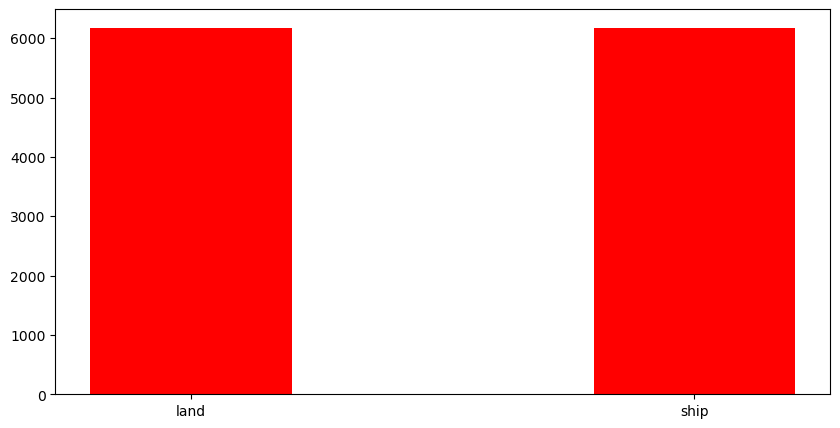

In [7]:
data = {'land':      0, 
        'ship': 0
       }

for cls in os.listdir(train_path):
    for img in os.listdir(train_path + '/' + cls):
        data[cls] = data[cls] + 1

keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, width = 0.4, color='r')

Land / No Ship Images


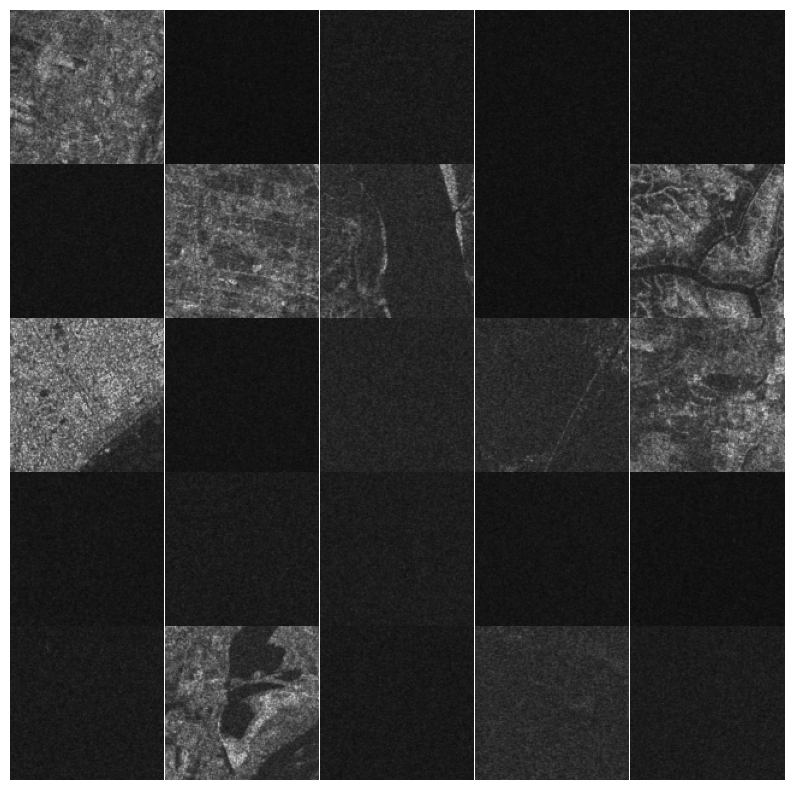

In [9]:
import glob
print("Land / No Ship Images")

# Use glob to find all image files in the specified directory and its subdirectories
multipleImages = glob.glob('ship_dataset/train/land/**/*.*', recursive=True)

# Filter out directories from the list of paths
image_files = [f for f in multipleImages if os.path.isfile(f)]

# Initialize counter for the subplot index
i = 0

# Set the figure size for the entire plot
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Adjust the layout of the subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through the first 25 images (or fewer if there are less than 25 images)
for im in image_files[:25]:
    # Read the image
    image = mpimg.imread(im)
    
    # Resize the image to 128x128
    image_resized = resize(image, (128, 128))
    
    # Convert grayscale images to RGB
    if len(image_resized.shape) == 2:  # If the image has only 2 dimensions, it's grayscale
        image_resized = gray2rgb(image_resized)
    
    # Display the image in the appropriate subplot
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_resized)
    plt.axis('off')
    
    # Increment the subplot index
    i += 1

# Show the plot with all subplots
plt.show()

Ship Images


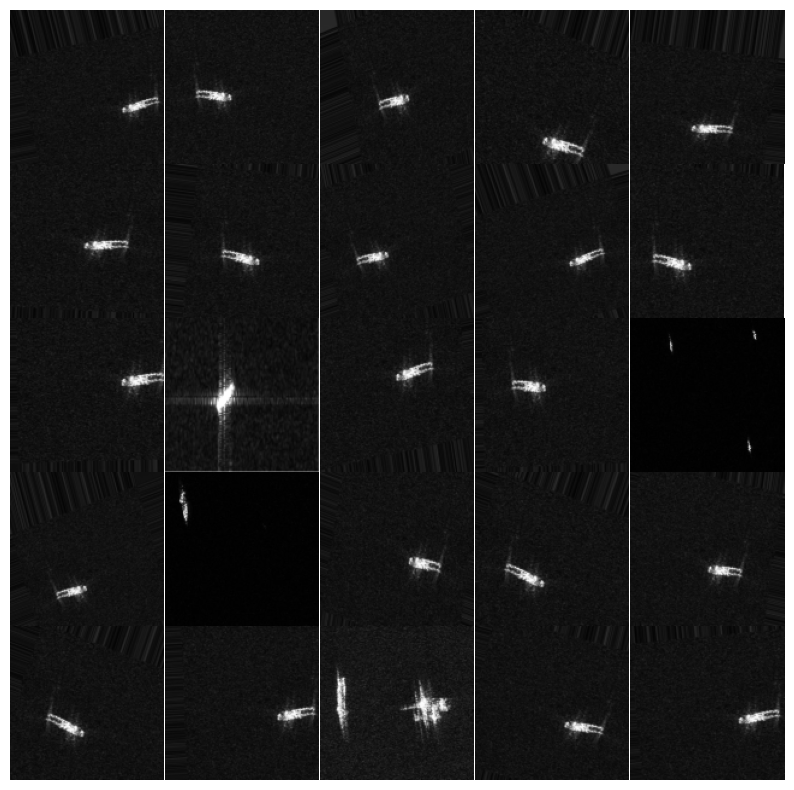

In [10]:
import glob
print("Ship Images")

# Use glob to find all image files in the specified directory and its subdirectories
multipleImages = glob.glob('ship_dataset/train/ship/**/*.*', recursive=True)

# Filter out directories from the list of paths
image_files = [f for f in multipleImages if os.path.isfile(f)]

# Initialize counter for the subplot index
i = 0

# Set the figure size for the entire plot
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Adjust the layout of the subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through the first 25 images (or fewer if there are less than 25 images)
for im in image_files[:25]:
    # Read the image
    image = mpimg.imread(im)
    
    # Resize the image to 128x128
    image_resized = resize(image, (128, 128))
    
    # Convert grayscale images to RGB
    if len(image_resized.shape) == 2:  # If the image has only 2 dimensions, it's grayscale
        image_resized = gray2rgb(image_resized)
    
    # Display the image in the appropriate subplot
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_resized)
    plt.axis('off')
    
    # Increment the subplot index
    i += 1

# Show the plot with all subplots
plt.show()

In [11]:
IMG_SIZE = 100
n_classes = 2

inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x1 = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)
x2 = layers.Rescaling(1./255)(x1)
x3 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                   padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x2)
x5 = layers.BatchNormalization(axis=-1)(x3)
x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
x7 = layers.Conv2D(filters=64, kernel_size=(3, 3), 
                   activation='relu', padding = 'same')(x6)
x9 = layers.BatchNormalization(axis=-1)(x7)
x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)

x11 = layers.Conv2D(filters=128, kernel_size=(3, 3), 
                    activation='relu', padding = 'same')(x10)
x13 = layers.BatchNormalization(axis=-1)(x11)
x14 = layers.MaxPool2D(pool_size=(2, 2))(x13)
x15 = layers.Conv2D(filters=256, kernel_size=(3, 3), 
                      activation='relu', padding = 'same')(x14)
x17 = layers.BatchNormalization(axis=-1)(x15)
x18 = layers.MaxPool2D(pool_size=(2, 2))(x17)
y1 = layers.Flatten()(x18)
y2 = layers.Dense(300, activation='relu')(y1)
y3 = layers.Dense(150, activation='relu')(y2)
y4 = layers.Dropout(0.25)(y3)
y = layers.Dense(n_classes, activation='softmax')(y4)   

model = keras.Model(inp,y)

In [12]:
EPOCHS = 10
BATCH_SIZE = 8
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics='accuracy')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 100, 100, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                           

In [16]:
history = model.fit(
    x=train_batches,
    validation_data=validation_batches,
    steps_per_epoch=len(train_batches),
    validation_steps=len(validation_batches),
    epochs=7,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping], 
    verbose=1
)


Epoch 1/7
   1/1112 [..............................] - ETA: 2:13 - loss: 1.6271e-05 - accuracy: 1.0000

2024-06-18 20:21:59.978356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1112/1112 [==============================] - 160s 144ms/step - loss: 0.0156 - accuracy: 0.9969 - val_loss: 0.0302 - val_accuracy: 0.9959
Epoch 2/7
1112/1112 [==============================] - 160s 144ms/step - loss: 0.0217 - accuracy: 0.9960 - val_loss: 0.0734 - val_accuracy: 0.9919
Epoch 2: early stopping


In [17]:
loss_and_metrics = model.evaluate(test_batches, batch_size=BATCH_SIZE, verbose=1)


  3/309 [..............................] - ETA: 9s - loss: 2.5652e-04 - accuracy: 1.0000 

2024-06-18 20:35:09.608391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


309/309 [==============================] - 12s 38ms/step - loss: 0.0323 - accuracy: 0.9961


  5/309 [..............................] - ETA: 8s

2024-06-18 20:35:22.746218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


309/309 [==============================] - 11s 37ms/step


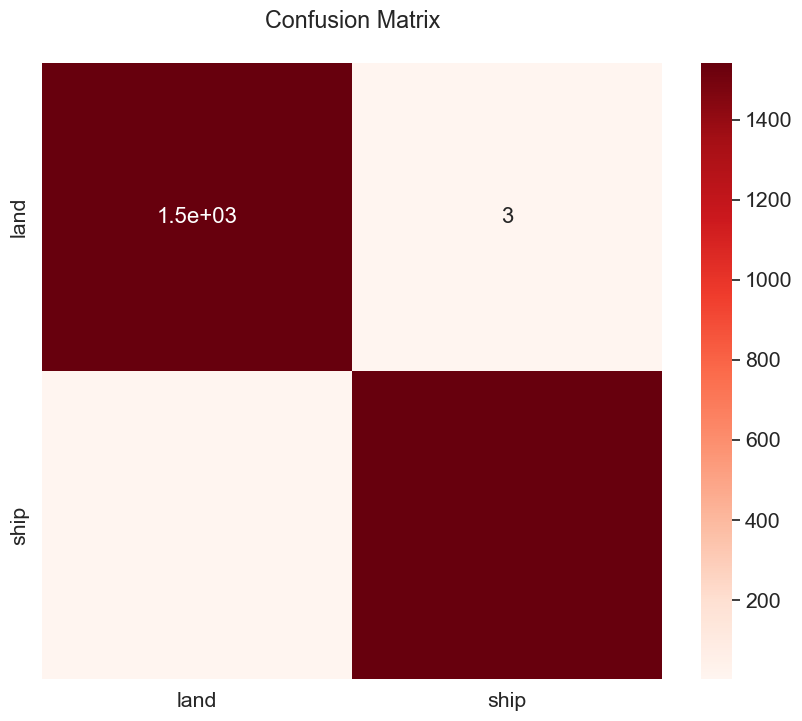

Classification Report

              precision    recall  f1-score   support

        land       0.99      1.00      1.00      1545
        ship       1.00      0.99      1.00      1545

    accuracy                           1.00      3090
   macro avg       1.00      1.00      1.00      3090
weighted avg       1.00      1.00      1.00      3090



In [18]:
num_classes = len(train_batches.class_indices)  
train_labels = train_batches.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = validation_batches.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_batches.filenames)  
nb_valid_samples = len(validation_batches.filenames)
nb_test_samples = len(test_batches.filenames)
Y_pred = model.predict(test_batches, nb_test_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_batches.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_batches.class_indices.keys()), list(test_batches.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Reds)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_batches.class_indices.keys())
print(classification_report(test_batches.classes, y_pred, target_names=target_names))

In [19]:
model.save('sar_ships.h5')